In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [116]:
df = pd.read_csv('HISTPOP_22032020221429392.csv')

In [118]:
age_groups = [
    '0 to 4', '5 to 9', '10 to 14', '15 to 19', '20 to 24', '25 to 29', '30 to 34', '35 to 39', '40 to 44', 
    '45 to 49', '50 to 54', '55 to 59', '60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84','85 and over'
]

In [119]:
ASSIGNMENT = {
    "0-4": ['0 to 4'],
    "5-14": ['5 to 9', '10 to 14'],
    "15-34": ['15 to 19', '20 to 24', '25 to 29', '30 to 34'],
    "35-59": ['35 to 39', '40 to 44', '45 to 49', '50 to 54', '55 to 59'],
    "60-79": ['60 to 64', '65 to 69', '70 to 74', '75 to 79'],
    "80+": ['80 to 84','85 and over']
}

def assign_consolidated_group(cohort):    
    for k,v in ASSIGNMENT.items():
        if cohort in v:
            return k

In [120]:
df['consolidated_age'] = df['Age'].apply(assign_consolidated_group)

In [125]:
df[
    (df['LOCATION'].isin(['DEU','ITA'])) &
    (df['SEX'].isin(['W','M']))
].groupby(['consolidated_age','LOCATION']).Value.sum().unstack().loc[ASSIGNMENT.keys()].to_clipboard()

# Helper

In [359]:
def combine_locality(series):
    region = series['Country/Region']
    sub_region = series['Province/State']
    if (region != sub_region) and not pd.isna(sub_region):
        return " - ".join([region,sub_region])
    else:
        return region
    
def load_data(data_type: str):
    base_str = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/" \
                          "csse_covid_19_time_series/time_series_covid19_{}_global.csv"

    
    df = pd.read_csv(base_str.format(data_type.lower()))

    df['combined locality'] = df.apply(combine_locality,axis=1)

    transposed = df.T
    header = transposed.iloc[-1]
    transposed = transposed.iloc[4:-1]
    transposed.columns = header
    transposed.index = pd.DatetimeIndex(transposed.index)
    
    return transposed

In [350]:
def find_similar_period(ref_data,target_data):
    date_range = pd.date_range(target_data.index.min(),target_data.index.max(), freq='D')
    end_date = target_data.index.max()

    distance = 100000

    for i in range(len(target_data)):    
        current_period = target_data[date_range[i:i+len(ref_data)]]
        if date_range[i+len(ref_data)] >= end_date:
            break
        current_distance = np.linalg.norm(ref_data.values - current_period.values)
        if current_distance < distance:
            distance = current_distance
            most_similiar_period = current_period
            start_date = most_similiar_period.index[0]
            
    return pd.Series(
        index=[f'Day: {_}' for _ in range(len(ref_data))],
        data=most_similiar_period.values,
        name=f'{target_data.name};{start_date.date()}'
    )

# Infection Numbers

In [360]:
_ = load_data('Confirmed')

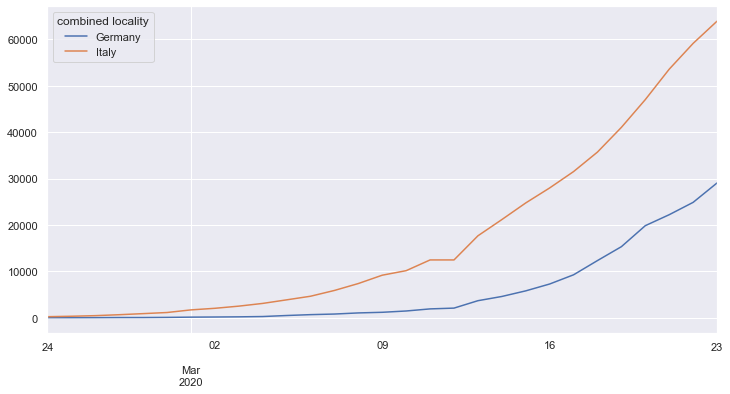

In [361]:
_.loc['24-02-2020':][['Germany','Italy']].plot()

In [362]:
data = _.loc['24-02-2020':][['Germany','Italy']].reset_index().melt(
    id_vars = ['index'],
    value_vars = ['Germany','Italy'],
    value_name = 'Infections'
)

data = data.rename(columns={'index':'Date','combined locality':'Country'})
data.Infections = data.Infections.astype(int)

In [366]:
data[data['Date'] == "2020-03-23"]

,Date,Country,Infections
28,2020-03-23,Germany,29056
57,2020-03-23,Italy,63927


Text(0.5, 1.0, 'Number of Infections by Country')

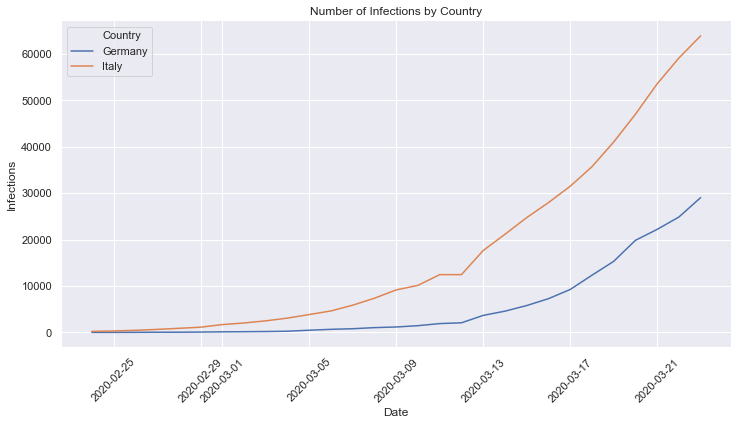

In [363]:
sns.set(
    rc={'figure.figsize':(12,6)},
    style='darkgrid'
)

chart = sns.lineplot(
    x='Date',
    y='Infections',
    hue='Country',
    data=data
)

sns.despine()
#chart.set_xticklabels([_.get_text() for _ in chart.get_xticklabels()], rotation=45)
#chart.set_xticklabels(rotation=30)
plt.xticks(rotation=45)
chart.set_title('Number of Infections by Country')

In [364]:
chart.get_figure().savefig("Infections.png",dpi=600)

# Infections - second part

In [437]:
_['US']

2020-01-22      0
2020-01-23      0
2020-01-24      0
2020-01-25      0
2020-01-26      0
             ... 
2020-03-19    200
2020-03-20    244
2020-03-21    307
2020-03-22    417
2020-03-23    557
Name: US, Length: 62, dtype: object

In [412]:
_ = load_data('Confirmed')
ger = _.loc['03-01-2020':]['Germany']

Text(0.5, 1.0, 'Number of Infections by Country (scaled to individual Day 0)')

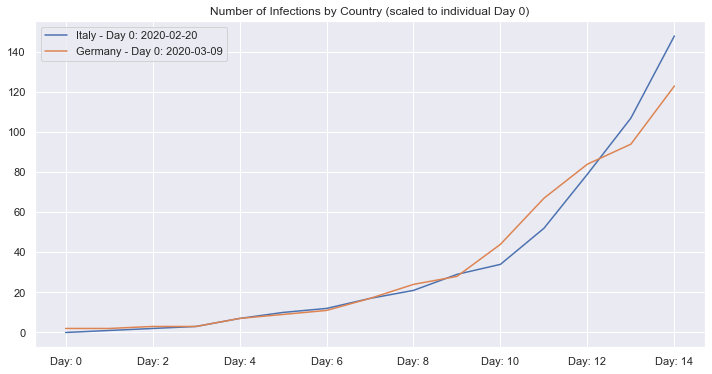

In [438]:
#rel_countries = set(_.iloc[-1].sort_values(ascending=False)[:'Germany'].index[:-1]) - {'China - Hubei', 'Korea, South'}
rel_countries = ['Italy']
res = pd.DataFrame()
for country in rel_countries:
    res = res.append(find_similar_period(ger,_[country]))
    
ordered_range = [f'Day: {_}' for _ in range(len(ger))]

res = res.append(pd.Series(
    index=ordered_range,
    data=ger.values,
    name=f'{ger.name};{ger.index.min().date()}'
))

ordered_countries = [
    ";".join(__) for __ in sorted([elem.split(';') for elem in res.T.columns], key = lambda x: x[1])
]

res = res[ordered_range]
res = res.T
res.columns = [elem.replace(';',' - Day 0: ') for elem in res.columns]

plot = res.plot()
plot.set_title('Number of Infections by Country (scaled to individual Day 0)')

In [416]:
plot.figure.savefig("Infections_Shifted.png",dpi=600)

# Deaths

In [376]:
_ = load_data('Deaths')

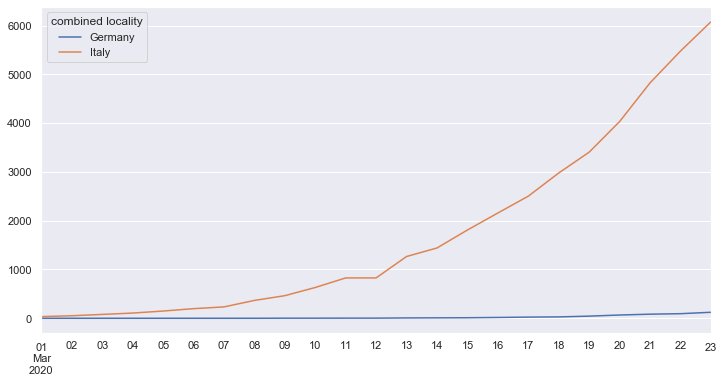

In [377]:
sns.set(
    rc={'figure.figsize':(12,6)},
    style='darkgrid'
)
_.loc['03-01-2020':][['Germany','Italy']].plot()

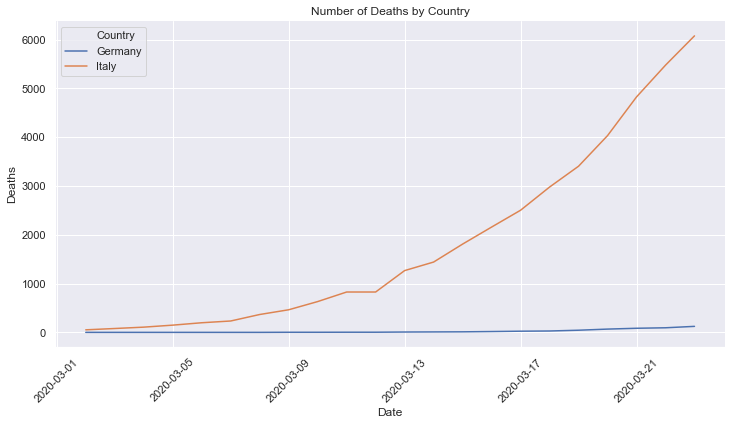

In [378]:
data = _.loc['03-02-2020':][['Germany','Italy']].reset_index().melt(
    id_vars = ['index'],
    value_vars = ['Germany','Italy'],
    value_name = 'Deaths'
)

data = data.rename(columns={'index':'Date','combined locality':'Country'})
data.Deaths = data.Deaths.astype(int)

sns.set(
    rc={'figure.figsize':(12,6)},
    style='darkgrid'
)

chart = sns.lineplot(
    x='Date',
    y='Deaths',
    hue='Country',
    data=data
)

sns.despine()
#chart.set_xticklabels([_.get_text() for _ in chart.get_xticklabels()], rotation=45)
#chart.set_xticklabels(rotation=30)
plt.xticks(rotation=45)
chart.set_title('Number of Deaths by Country')
chart.get_figure().savefig("Deaths.png",dpi=600)

In [379]:
data[data['Date'] == "2020-03-23"]

,Date,Country,Deaths
21,2020-03-23,Germany,123
43,2020-03-23,Italy,6077


# Deaths Shifted

In [439]:
_ = load_data('Deaths')
ger = _.loc['03-09-2020':]['Germany']

Text(0.5, 1.0, 'Number of Deaths by Country (scaled to individual Day 0)')

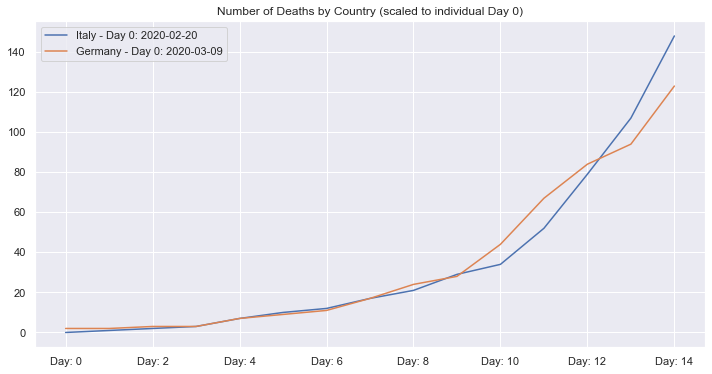

In [440]:
rel_countries = set(_.iloc[-1].sort_values(ascending=False)[:'Germany'].index[:-1]) - {'China - Hubei', 'Korea, South'}
rel_countries = ['Italy']
res = pd.DataFrame()
for country in rel_countries:
    res = res.append(find_similar_period(ger,_[country]))
    
ordered_range = [f'Day: {_}' for _ in range(len(ger))]

res = res.append(pd.Series(
    index=ordered_range,
    data=ger.values,
    name=f'{ger.name};{ger.index.min().date()}'
))

ordered_countries = [
    ";".join(__) for __ in sorted([elem.split(';') for elem in res.T.columns], key = lambda x: x[1])
]

res = res[ordered_range]
res = res.T
res.columns = [elem.replace(';',' - Day 0: ') for elem in res.columns]

plot = res.plot()
plot.set_title('Number of Deaths by Country (scaled to individual Day 0)')

In [435]:
plot.figure.savefig("Deaths_Shifted.png",dpi=600)

# CFR

In [441]:
current_date = "2020-03-23"

a = load_data('confirmed')[['Germany','Italy']].loc[current_date]
b = load_data('deaths')[['Germany','Italy']].loc[current_date]
res = pd.concat([a,b],axis=1)
res.columns = ['Infected','Dead']

In [442]:
res['CFR'] = res['Dead']/res['Infected']

In [443]:
res

,Infected,Dead,CFR
combined locality,,,
Germany,29056,123,0.0042332
Italy,63927,6077,0.0950616


# Case Age distribution

In [309]:
cases_by_age = pd.read_clipboard()
cases_by_age.to_csv('cases_by_age.csv')

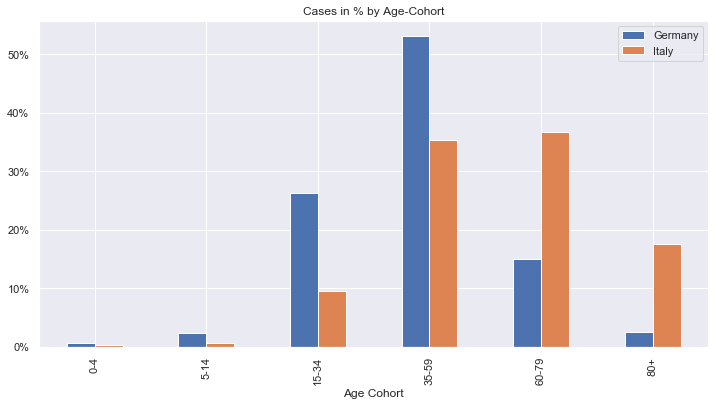

In [312]:
chart = cases_by_age.applymap(lambda x: float(x.replace('%',''))).plot(kind='bar')
ylabels = ['{:,.0f}'.format(x) + '%' for x in  chart.get_yticks()]
chart.set_title('Cases in % by Age-Cohort')
chart.set_xlabel('Age Cohort')
chart.set_yticklabels(ylabels)
chart.get_figure().savefig("Cases_By_Age.png",dpi=600)

# Age

In [283]:
age = pd.read_clipboard()
age.to_csv('age.csv')

[Text(0, 0, '0%'),
 Text(0, 0, '5%'),
 Text(0, 0, '10%'),
 Text(0, 0, '15%'),
 Text(0, 0, '20%'),
 Text(0, 0, '25%'),
 Text(0, 0, '30%'),
 Text(0, 0, '35%'),
 Text(0, 0, '40%')]

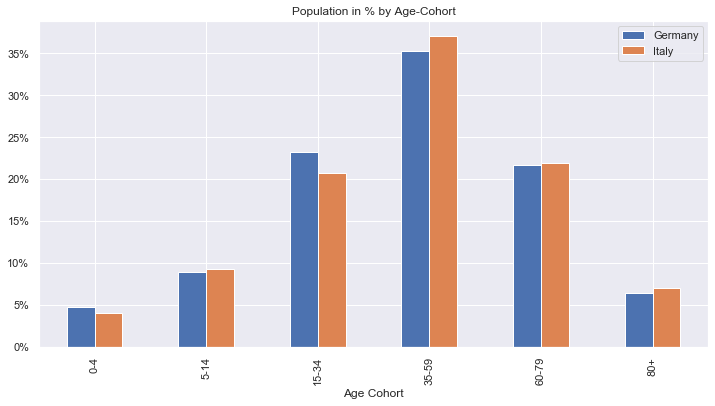

In [307]:
chart = age.applymap(lambda x: float(x.replace('%',''))).plot(kind='bar')
ylabels = ['{:,.0f}'.format(x) + '%' for x in  chart.get_yticks()]
chart.set_title('Population in % by Age-Cohort')
chart.set_xlabel('Age Cohort')
chart.set_yticklabels(ylabels)

In [308]:
chart.get_figure().savefig("Population.png",dpi=600)

# Testing Capabilities

Text(0.5, 1.0, 'Number of Administered Tests')

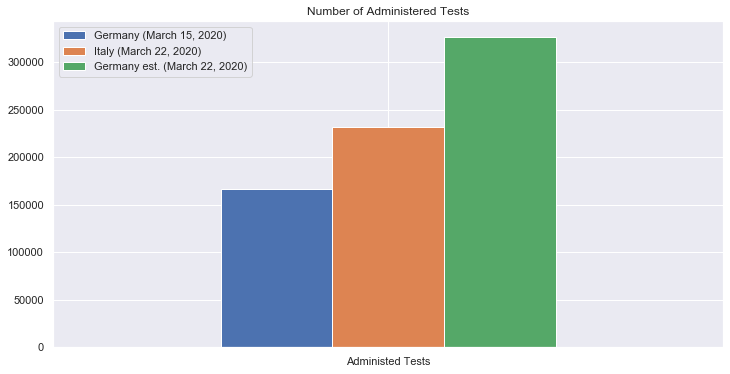

In [403]:
chart = pd.DataFrame(
    index = ['Germany (March 15, 2020)','Italy (March 22, 2020)','Germany est. (March 22, 2020)'],
    data = [167000,232222,167000+160000],
    columns = ['Administed Tests']
).T.plot(kind='bar')
plt.xticks(rotation=0)
chart.set_title('Number of Administered Tests')

In [404]:
chart.figure.savefig('Tests.png',dpi=600)

In [405]:
current_date = "2020-03-22"

a = load_data('confirmed')[['Germany','Italy']].loc[current_date]
b = load_data('deaths')[['Germany','Italy']].loc[current_date]
res = pd.concat([a,b],axis=1)
res.columns = ['Infected','Dead']

In [407]:
res['Tests'] = [167000+160000,232222]

In [410]:
res['Tests/Infected'] = res['Tests']/res['Infected']

In [411]:
res

,Infected,Dead,Tests,Tests/Infected
combined locality,,,,
Germany,24873,94,327000,13.1468
Italy,59138,5476,232222,3.92678


In [444]:
!open .